<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 

In [3]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [4]:
#Accessing google colab and append custom functions folder
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Defining the path and traversing the contents in the folder
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

data_preparation_imdb_rev0.py
.ipynb_checkpoints
__pycache__


In [6]:
sys.path = list(set(sys.path))

In [7]:
sys.path

['',
 '/usr/lib/python39.zip',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/usr/lib/python3.9',
 '/content',
 '/usr/lib/python3.9/lib-dynload',
 '/env/python',
 '/content/drive/MyDrive/NLP/user-defined',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions']

In [8]:
!pip install torchmetrics -qq

In [9]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [10]:
from data_preparation_imdb_rev0 import *

In [11]:
#Loading the contents from folder
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [12]:
multiLabel_Data.columns #Printing all df columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [13]:
multiLabel_Data.shape

(47427, 3)

In [14]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer   #Implementing MultiLabelBinarizer for multiLabel classification

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
one_hot_labels= mlb.fit_transform(multiLabel_Data['Tag_Number'])
for i in range(len(mlb.classes_)):
    multiLabel_Data[f"one_hot_{mlb.classes_[i]}"] = one_hot_labels[:, i]

In [16]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number', 'one_hot_0', 'one_hot_1',
       'one_hot_2', 'one_hot_3', 'one_hot_4', 'one_hot_5', 'one_hot_6',
       'one_hot_7', 'one_hot_8', 'one_hot_9'],
      dtype='object')

In [17]:
X_final = multiLabel_Data['cleaned_text'].values

In [18]:
y_final = multiLabel_Data.loc[:, 'one_hot_0':'one_hot_9'].values    #Checking one-hot encoding values
unique_labels = np.unique(y_final)
print(unique_labels)

[0 1]


In [19]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427, 10)


#Create Train/Test/Valid Split

In [20]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4)   #Splitting the data

In [21]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5)

In [22]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [23]:
trainset = CustomDataset(X_train,y_train)   #Creating train, valid & test set using custom class
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

In [24]:
print(np.unique(y_train), np.unique(y_valid), np.unique(y_test))

[0 1] [0 1] [0 1]


#Create vocab

In [25]:
multilabel_vocab = get_vocab(trainset, min_freq=2)   #Creating vocab

In [26]:
len(multilabel_vocab)

91966

In [27]:
valid_multilabel_vocab = get_vocab(validset, min_freq=2)

#Meta Data

In [28]:
from types import SimpleNamespace    #Defining parameters 

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 10,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [29]:
def collate_batch_multilabel(batch, vocab):   #Defined collate batch function to support multilabel classification
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    return (texts, offsets), labels

In [30]:
from functools import partial   #Defined all required class instances & Other variables
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch_multilabel, vocab=multilabel_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                         collate_fn=collate_fn)

# cross entropy loss function
loss_function = torch.nn.BCEWithLogitsLoss()
# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
for (texts, offsets), labels in train_loader:   #Traversing the train_loader
  print(labels, texts, offsets)
  break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]) tensor([  886,    92, 11789,  ...,   753,  2031,    38]) tensor([    0,    36,    70,   136,   282,   326,   474,   528,   596,   633,
          683,   884,   952,  1083,  1163,  1334,  1358,  1384,  1587,  1608,
         1668,  1766,  1993,  2136,  2208,  2279,  2299,  2348,  2511,  2555,
         2596,  2854,  2913,  2985,  3026,  3095,  3138,  3212,  3270,  3321,
         3694,  3715,  3800,  3835,  3878,  3910,  4014,  4251,  4318,  4343,
         4368,  4427,  4457,  4493,  4558,  4695,  4802,  4917,  4993,  5021,
         5071,  5108,  5129,  5165,  5231,  5261,  5387,  5457,  5507,  5539,
         5581,  5653,  5683,  5712,  5788,  5798,  5827,  5936,  5947,  5974,
         6032,  6113,  6134,  6245,  6272,  6314,  6340,  6365,  

<ipython-input-29-0afa194fa4de>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels, dtype=torch.float32)


#Training Model

In [32]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,         
                  criterion=loss_function, device=device)       #creating class instance

In [33]:
from torchmetrics.classification import MultilabelHammingDistance     #Defining other class instances and variables
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
train_metric = MultilabelHammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
valid_metric = MultilabelHammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=1, save_last_epoch=False)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

Add a brief description about the metric and why it is a good metric for multilabel classification problems.


Answer: MultilabelHammingDistance is a metric used for evaluating the performance of multilabel classification models. It calculates the proportion of labels that are incorrectly predicted by the model, i.e., the average number of labels that differ between the predicted and true labels across all samples. It takes into account the fact that each sample can have multiple labels, and penalizes the model for making incorrect predictions for each label independently. This is different from other metrics like accuracy, which only consider the overall percentage of correctly classified samples, without taking into account the number of labels each sample has. And robust to imbalanced classes, which is a common issue in multilabel classification problems where some labels might be more frequent than others. Because it considers the total number of label predictions rather than the number of correctly predicted labels, making it less sensitive to the distribution of the labels.

> Indented block



In [34]:
trainer.sanity_check(num_classes=2)   #Doing sanity check

Actual loss: 0.7230636477470398
Expected Theoretical loss: 0.6931471805599453


In [35]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)    #Training the model

Epoch 1/5 - Train Loss: 0.5720, Train Metric: 0.2673, Train Time: 0:00:03.323377
Epoch 1/5 - Val Loss: 0.2369, Val Metric: 0.0766, Val Time: 0:00:00.847857

Epoch 2/5 - Train Loss: 0.2360, Train Metric: 0.0851, Train Time: 0:00:03.360040
Epoch 2/5 - Val Loss: 0.1627, Val Metric: 0.0597, Val Time: 0:00:00.850233

Epoch 3/5 - Train Loss: 0.1777, Train Metric: 0.0640, Train Time: 0:00:03.217046
Epoch 3/5 - Val Loss: 0.1429, Val Metric: 0.0526, Val Time: 0:00:00.839723

Epoch 4/5 - Train Loss: 0.1511, Train Metric: 0.0536, Train Time: 0:00:03.259341
Epoch 4/5 - Val Loss: 0.1307, Val Metric: 0.0480, Val Time: 0:00:00.833663

Epoch 5/5 - Train Loss: 0.1319, Train Metric: 0.0473, Train Time: 0:00:03.409073
Epoch 5/5 - Val Loss: 0.1208, Val Metric: 0.0443, Val Time: 0:00:00.831465



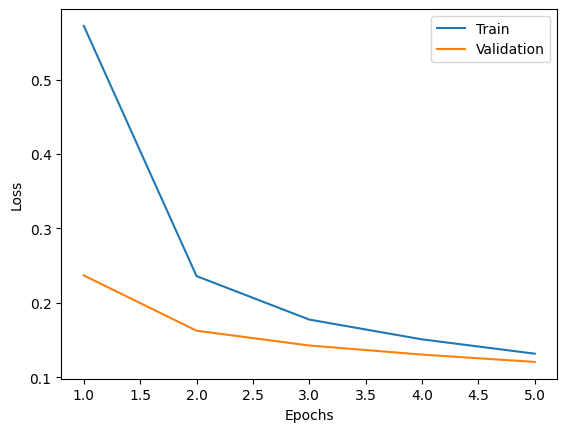

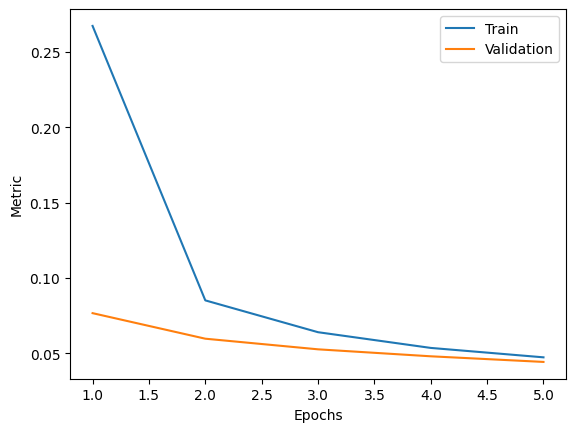

In [36]:
trainer.plot_history()   #plotting the train & validation loss 

In [37]:
trainer.best_epoch   #Displaying best epoch number 

5

In [38]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'     #Saving the epoch
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/MyDrive/NLP/assignment6/rev2/checkpoint_2023-04-10_03-04-32_best.pt'.


In [39]:
trainer.train(num_epochs=10, multilabel=True)  #Rerunning the model again 10 times

Epoch 1/10 - Train Loss: 0.1175, Train Metric: 0.0418, Train Time: 0:00:03.271289
Epoch 1/10 - Val Loss: 0.1151, Val Metric: 0.0419, Val Time: 0:00:00.879514

Epoch 2/10 - Train Loss: 0.1062, Train Metric: 0.0379, Train Time: 0:00:03.247995
Epoch 2/10 - Val Loss: 0.1093, Val Metric: 0.0393, Val Time: 0:00:00.818000

Epoch 3/10 - Train Loss: 0.0967, Train Metric: 0.0352, Train Time: 0:00:03.194657
Epoch 3/10 - Val Loss: 0.1068, Val Metric: 0.0383, Val Time: 0:00:00.857526

Epoch 4/10 - Train Loss: 0.0878, Train Metric: 0.0315, Train Time: 0:00:03.253004
Epoch 4/10 - Val Loss: 0.1045, Val Metric: 0.0369, Val Time: 0:00:00.814215

Epoch 5/10 - Train Loss: 0.0808, Train Metric: 0.0289, Train Time: 0:00:03.204365
Epoch 5/10 - Val Loss: 0.1022, Val Metric: 0.0356, Val Time: 0:00:00.816991

EarlyStopping counter: 1 out of 5
Epoch 6/10 - Train Loss: 0.0738, Train Metric: 0.0263, Train Time: 0:00:03.284957
Epoch 6/10 - Val Loss: 0.1023, Val Metric: 0.0352, Val Time: 0:00:00.819969

Epoch 7/10 -

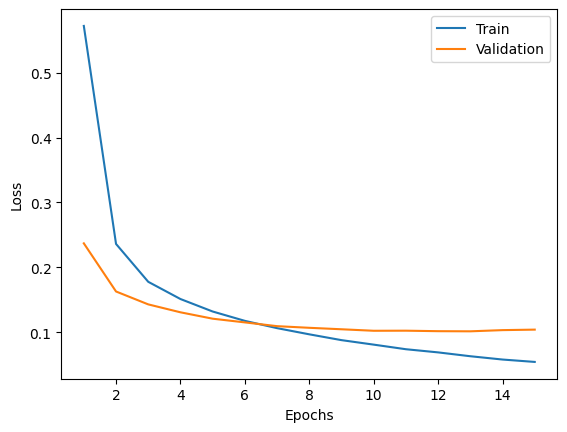

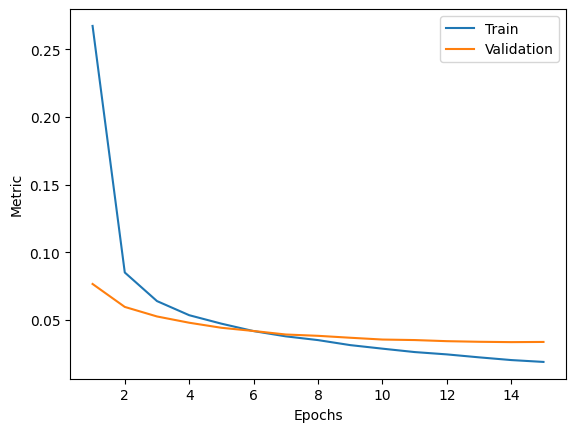

In [40]:
trainer.plot_history()  #Replotting the train & valid loss

In [41]:
trainer.best_epoch #displaying the best epoch

12

#Get Accuracy, Predictions

In [43]:
test_multilabel_vocab = get_vocab(testset, min_freq=2)   #Create test vocab

In [44]:
collate_fn = partial(collate_batch_multilabel, vocab=test_multilabel_vocab)    #Creating test loader
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [50]:
for (texts, offsets), labels in test_loader:   #Traversing the test loader
  print(labels, texts, offsets)
  break

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.]]) tensor([   1,    2,    3,  ..., 1895,  216,  109]) tensor([   0,  100,  141,  236,  275,  315,  369,  470,  500,  524,  543,  622,
         651,  855, 1018, 1132, 1173, 1217, 1297, 1357, 1478, 1563, 1618, 1765,
        1797, 1870, 1948, 1983, 2080, 2164, 2206, 2267, 2323, 2399, 2491, 2507,
        2541, 2582, 2602, 2650, 2677, 2765, 2803, 2837, 2877, 2961, 3051, 3088,
        3177, 3239, 3360, 3436, 3460, 3491, 3640, 3665, 3708, 3792, 3862, 3958,
        4055, 4128, 4196, 4300, 4400, 4646, 4783, 4802, 4964, 5077, 5097, 5135,
        5241, 5254, 5343, 5364, 5391, 5408, 5481, 5496, 5614, 5704, 5806, 5830,
        6051, 6074, 6133, 6300, 6679, 7123, 7167, 7233, 7277, 7318, 7406, 7483,
        7531, 7560, 7639, 7705, 7749, 7774, 7808, 7826,

In [46]:
#Predicting train, valid & test dataset
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True, multilabel=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True, multilabel=True)
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True, multilabel=True)

In [47]:
print(target_train.shape, predictions_train.shape)   #Displaying the train, valid & test target & predicted shape
print(target_valid.shape, predictions_valid.shape)
print(target_test.shape, predictions_test.shape)

torch.Size([28456, 10]) torch.Size([28456, 10])
torch.Size([9485, 10]) torch.Size([9485, 10])
torch.Size([9486, 10]) torch.Size([9486, 10])


In [48]:
import torchmetrics

In [49]:
#Calculating the multilable F1 score & hamming distance
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
num_classes = target_train.shape[-1]
f1_score_train = multilabel_f1_score(target_train, predictions_train, average='micro',num_labels=num_classes)
hamming_distance_train = multilabel_hamming_distance(target_train,predictions_train, num_labels=num_classes)
print("Train F1 Score: ",f1_score_train, " Train hamming distance: ", hamming_distance_train)
num_classes = target_valid.shape[-1]
f1_score_valid = multilabel_f1_score(target_valid,predictions_valid, average='micro',num_labels=num_classes)
hamming_distance_valid = multilabel_hamming_distance(target_valid,predictions_valid, num_labels=num_classes)
print("Train F1 Score: ",f1_score_valid, " Train hamming distance: ", hamming_distance_valid)
num_classes = target_test.shape[-1]
f1_score_test = multilabel_f1_score(target_test, predictions_test, average='micro', num_labels=num_classes)
hamming_distance_test = multilabel_hamming_distance(target_test,predictions_test,num_labels=num_classes)
print("Test F1 Score: ",f1_score_test, " Test hamming distance: ", hamming_distance_test)

Train F1 Score:  tensor(0.9756)  Train hamming distance:  tensor(0.0101)
Train F1 Score:  tensor(0.9177)  Train hamming distance:  tensor(0.0338)
Test F1 Score:  tensor(0.4358)  Test hamming distance:  tensor(0.2261)
